## Feature Extraction for Apple Stock Price

Stock Trend Prediction 

In [1]:
#importing libraries
import pandas as pd
import numpy as np

#Import yahoo finance library
import yfinance as yf

#Import cufflinks for visualisation
import cufflinks as cf
cf.set_config_file(offline=True)

#Visualisation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')
import seaborn as sns

import missingno as msno

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
# pip install missingno

Import 5 years of data from Yahoo! Finance for stock Apple 

In [3]:
#Fetching stock data by specifying dates
df=yf.download('AAPL',start='2015-01-01', end='2020-12-31',progress=False)#

#Checking first five rows
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,28.205000,28.282499,27.552500,27.594999,24.915258,165613600
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.678253,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.983025,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.985285,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.321611,160423600


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,132.160004,132.429993,130.779999,130.960007,129.801285,88223700
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.802338,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.480591,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,133.676666,121047300
2020-12-30,135.580002,135.990005,133.399994,133.720001,132.536865,96452100


Define our Features

In [5]:
#Calculating Log Returns using numpy log function 
df['Daily_Return']=np.log(df).diff()['Adj Close'].dropna()
#df['return_1d']=df['Daily_Return'].shift(1)    
#df['return_2d']=df['Daily_Return'].shift(2)
#df['return_5d']=df['Daily_Return'].shift(5)
#df['Ret_1M']=df['Daily_Return'].rolling(20).sum()

df['O-C']=df['Open']-df['Close']
df['H-L']=df['High']-df['Low']

#Momentum Factors
df['Momentum_1d']=df['Adj Close']-df['Adj Close'].shift(1)
df['Momentum_2d']=df['Adj Close']-df['Adj Close'].shift(2)
df['Momentum_5d']=df['Adj Close']-df['Adj Close'].shift(5)

#Moving Average Factors
df['MA_5d'] = df['Adj Close'].rolling(5).mean()
df['MA_10d'] = df['Adj Close'].rolling(10).mean()
df['MA_20d'] = df['Adj Close'].rolling(20).mean()
df['MA_50d'] = df['Adj Close'].rolling(50).mean()

#Bollinger Bands
df['Bol_MA_20d'] = df['Close'].rolling(20).mean() #Close not adjusted to test if output same
df['20dSD']= df['Close'].rolling(20).std()
df['bollinger_up'] = df['MA_20d'] + df['20dSD']* 2 # Calculate top band
df['bollinger_down'] = df['MA_20d'] - df['20dSD']*2 # Calculate bottom band

#EWMA Factors
n_obs=len(df)
alpha_EWM=2/(n_obs+1)

df['EMA']=df['Adj Close'].ewm(alpha=alpha_EWM).mean()
df['EMA_5d']=df['Adj Close'].ewm(5,adjust=False).mean()
df['EMA_10d']=df['Adj Close'].ewm(10,adjust=False).mean()
df['EMA_20d']=df['Adj Close'].ewm(20,adjust=False).mean()

#df['Sign']=np.sign(df['Daily_Return'])
#df['Sign M_1d']=np.sign(df['Momentum_1d']) 
#df['Sign M_2d']=np.sign(df['Momentum_2d'])
#df['Sign M_5d']=np.sign(df['Momentum_5d'])

#Stochastic K and D Factors
df['diff'] = df['Daily_Return'].diff(1)
df['gain'] = df['diff'].clip(lower=0).round(2)
df['loss'] = df['diff'].clip(upper=0).abs().round(2)
# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['High'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['Low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['Close'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


#MACD Factors

# Get the 12-day EMA of the closing price
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
# Get the 26-day EMA of the closing price
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d
# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s
# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)




In [6]:
#Overlap Studies Indicators - to be done

#Kaufman Adpative Moving Average (DEMA)
    #Moving average designed to be responsive to market trends and volatility

#MESA Adaptive Moving Average (MAMA)
    #Adjusts to movement in price based on the rate of change of phase as determined by the Hilbert transform discriminator
    

#Volume Indicators

#Chaikin A/D Line (ADL)
    #Estimates the Advance/Decline of the market
    
#On Balance Volume (OBV)
    #Uses Volume Flow to forecast changes in price of stock
    
#Momentum Indicators

#Average Directional Movement Index (ADX)
    #Measures how srong or weak a trend is over time
    
#Aroon
    #Used to find changes in trends in the price of an asset
    
#Commodity Channel Index (CCI)
    #Determine the price level now relative to an average price level of a period of time
    
#Money Flow Index (MFI)
    #Utilise price and volume to identify buying and selling pressures
    
#Relative Strength Index (RSI)
    #Deermines the strength of current price in relation to preceeding price
    
#Ultimate Oscillator (ULTOSC)
    #Estimates the price momentum of a security asset across different time frames
    
#Williams'%R(WILLR)
    #Indicates the position of the last closing price relative to the highest and lowest price over a time period


In [7]:
df.to_excel('Feature_Data.xlsx')
df.tail(10)


,Open,High,Low,Close,Adj Close,Volume,Daily_Return,O-C,H-L,Momentum_1d,...,diff,gain,loss,n_high,n_low,%K,%D,macd,macd_h,macd_s
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-16,127.410004,128.369995,126.559998,127.809998,126.679146,98208600,-0.000548,-0.399994,1.809998,-0.069389,...,-0.049424,0.00,0.05,128.369995,116.220001,95.390964,88.007087,2.297191,0.526642,1.770549
2020-12-17,128.899994,129.580002,128.039993,128.699997,127.561279,94359800,0.006939,0.199997,1.540009,0.882133,...,0.007487,0.01,0.00,129.580002,116.809998,93.108813,96.114212,2.549455,0.623125,1.926330
2020-12-18,128.960007,129.100006,126.120003,126.660004,125.539330,192541500,-0.015978,2.300003,2.980003,-2.021950,...,-0.022917,0.00,0.02,129.580002,120.010002,69.488001,85.995926,2.555310,0.503184,2.052126
2020-12-21,125.019997,128.309998,123.449997,128.229996,127.095428,121251600,0.012319,-3.209999,4.860001,1.556099,...,0.028297,0.03,0.00,129.580002,120.150002,85.683923,82.760246,2.656018,0.483113,2.172905
2020-12-22,131.610001,134.410004,129.649994,131.880005,130.713120,168904800,0.028067,-0.270004,4.760010,3.617691,...,0.015748,0.02,0.00,134.410004,120.150002,82.258076,79.143333,2.995821,0.658333,2.337488
2020-12-23,132.160004,132.429993,130.779999,130.960007,129.801285,88223700,-0.007000,1.199997,1.649994,-0.911835,...,-0.035067,0.00,0.04,134.410004,120.150002,75.806477,81.249492,3.154518,0.653624,2.500894
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.802338,54930100,0.007683,-0.649994,2.360001,1.001053,...,0.014683,0.01,0.00,134.410004,120.150002,82.889186,80.317913,3.323474,0.658064,2.665410
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.480591,124486200,0.035141,-2.699997,3.830002,4.678253,...,0.027458,0.03,0.00,137.339996,120.150002,96.218766,84.971476,3.794496,0.903269,2.891227
2020-12-29,138.050003,138.789993,134.339996,134.869995,133.676666,121047300,-0.013404,3.180008,4.449997,-1.803925,...,-0.048546,0.00,0.05,138.789993,120.150002,78.969958,86.025970,3.975103,0.867101,3.108002


Text(0.5, 1.0, 'APPLE Stock Price Performance')

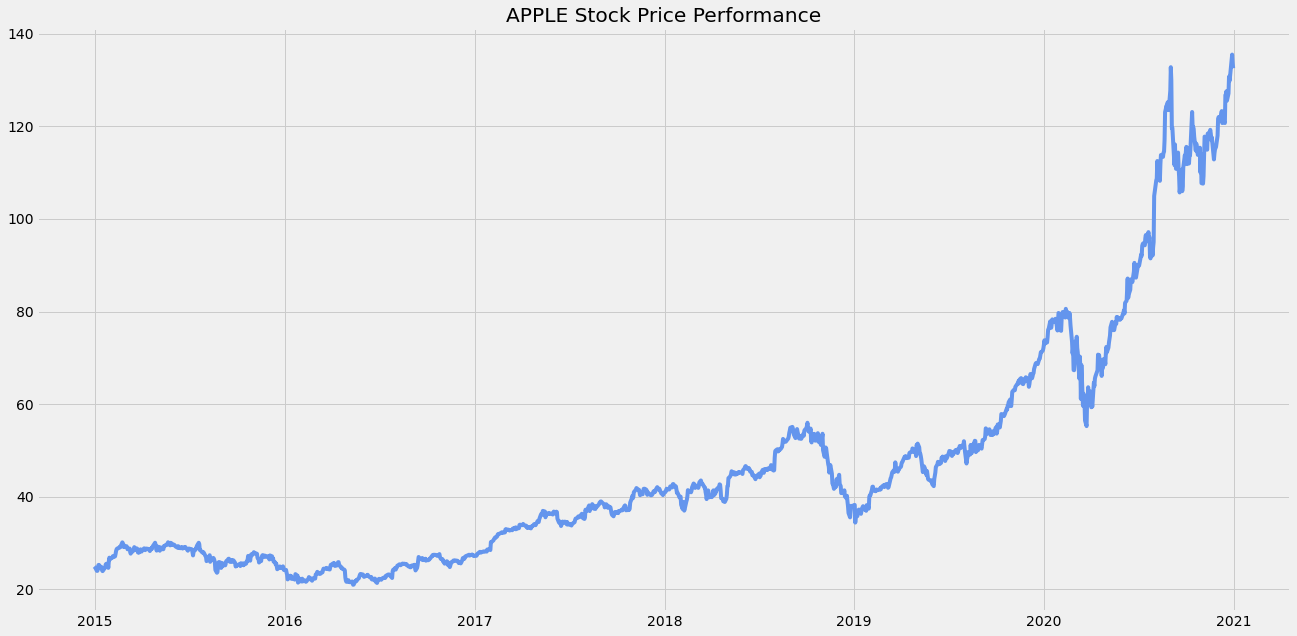

In [8]:
#Visualise raw price series
plt.plot(df['Adj Close'],color='cornflowerblue')
plt.title('APPLE Stock Price Performance')

Set negative returns equal to 1 and positive returns equal to 0.  A return is positive if it is above 0.004.  This is because of the clustering of returns around 0, the transactional and frictional costs of trading and the emphasis on correctly classifying a negative return.

In [9]:
df['Target']=np.where((df['Adj Close'].shift(-1))>df['Adj Close']*(1.004),0,1)
df= df[:-1]
#df = df.dropna(axis=0)
df.shape


(1510, 35)

In [10]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,O-C,H-L,Momentum_1d,...,gain,loss,n_high,n_low,%K,%D,macd,macd_h,macd_s,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-22,131.610001,134.410004,129.649994,131.880005,130.713120,168904800,0.028067,-0.270004,4.760010,3.617691,...,0.02,0.00,134.410004,120.150002,82.258076,79.143333,2.995821,0.658333,2.337488,1
2020-12-23,132.160004,132.429993,130.779999,130.960007,129.801285,88223700,-0.007000,1.199997,1.649994,-0.911835,...,0.00,0.04,134.410004,120.150002,75.806477,81.249492,3.154518,0.653624,2.500894,0
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.802338,54930100,0.007683,-0.649994,2.360001,1.001053,...,0.01,0.00,134.410004,120.150002,82.889186,80.317913,3.323474,0.658064,2.665410,0
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.480591,124486200,0.035141,-2.699997,3.830002,4.678253,...,0.03,0.00,137.339996,120.150002,96.218766,84.971476,3.794496,0.903269,2.891227,1
2020-12-29,138.050003,138.789993,134.339996,134.869995,133.676666,121047300,-0.013404,3.180008,4.449997,-1.803925,...,0.00,0.05,138.789993,120.150002,78.969958,86.025970,3.975103,0.867101,3.108002,1


In [11]:
df['Target'].value_counts()

1    886
0    624
Name: Target, dtype: int64

<AxesSubplot:>

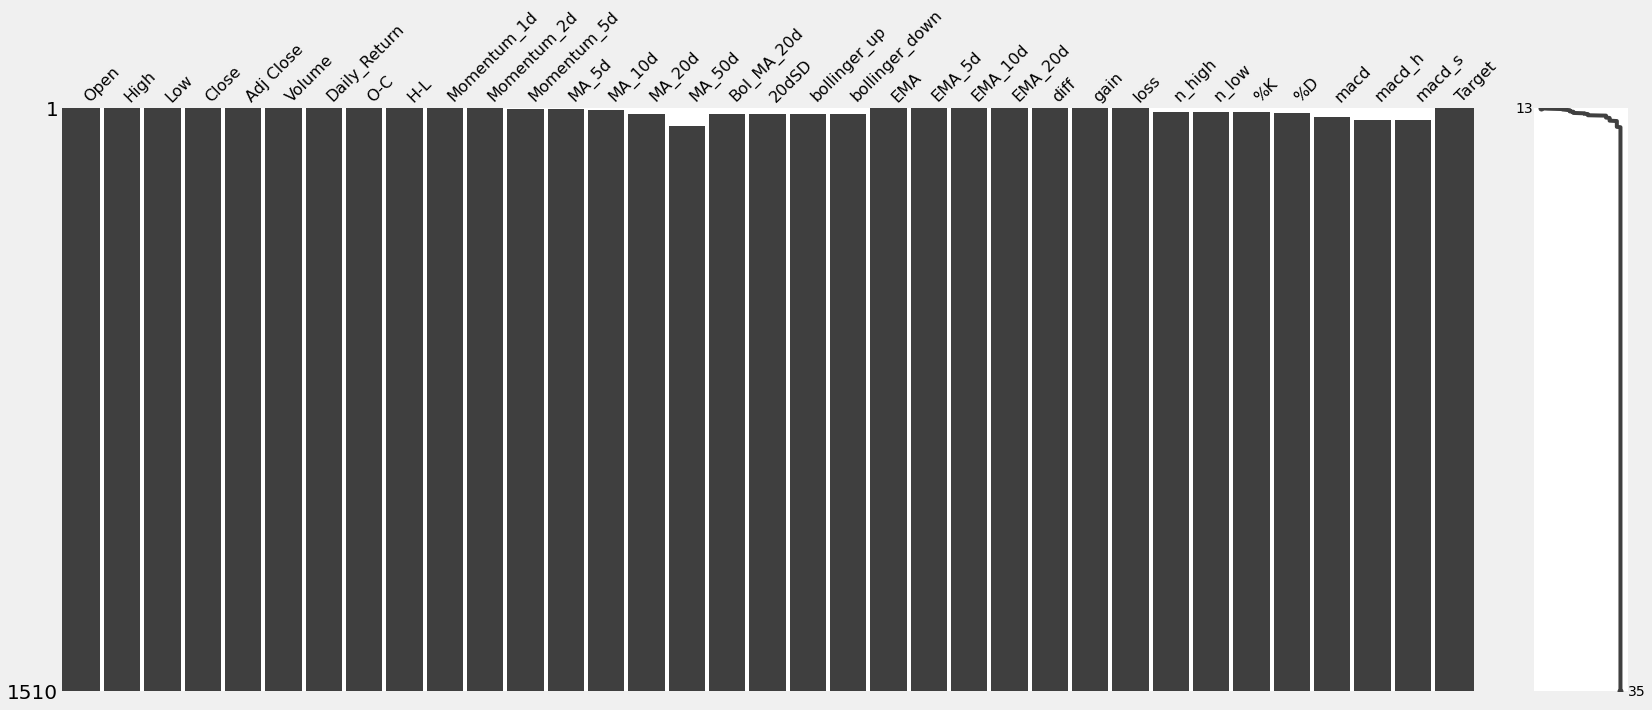

In [12]:
msno.matrix(df)

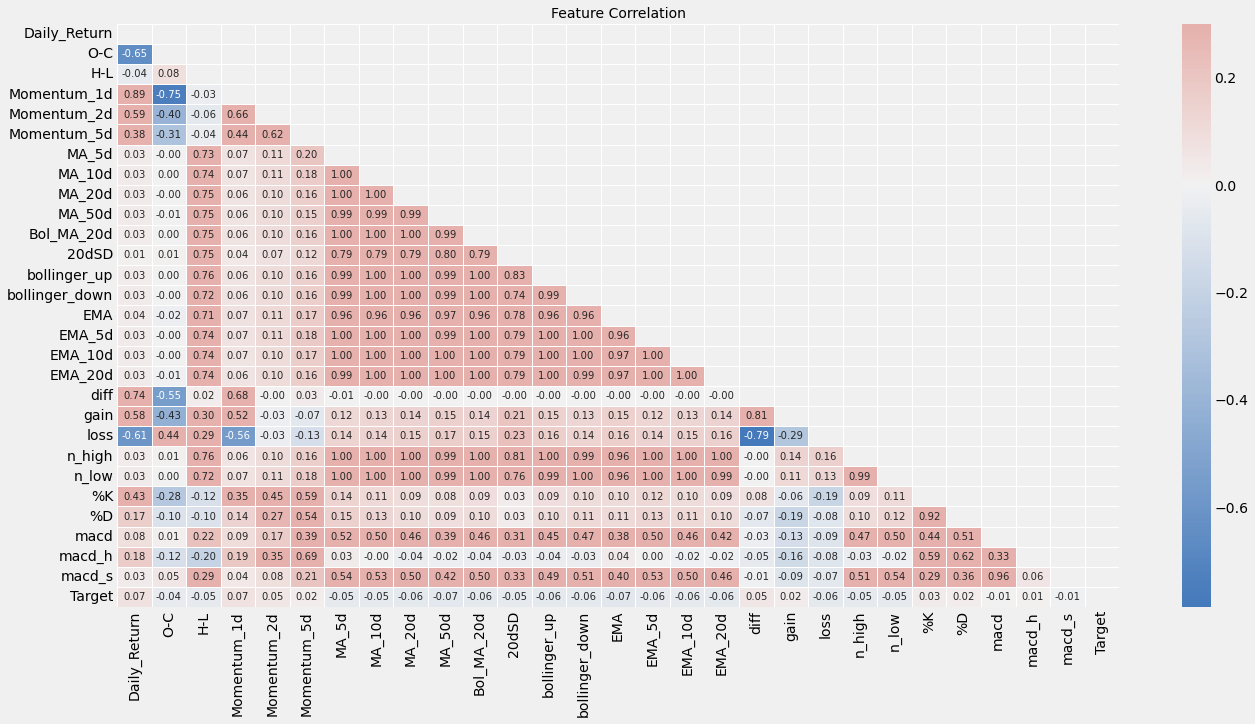

In [13]:
#Derive features correlation
corrmat=df.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1).corr()

#Visualise feature correlation
fig,ax=plt.subplots()

#Generate a mask for the upper triangle
mask=np.triu(np.ones_like(corrmat,dtype=bool))
#Generate a custom diverging colormap
cmap=sns.diverging_palette(250,15,as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat,annot=True,annot_kws={"size":10},fmt="0.2f", mask=mask, cmap=cmap, vmax=.3,center=0,
           square=False, linewidths=.5, cbar_kws={"shrink": 1})

ax.set_title('Feature Correlation', fontsize=14, color='black');

# CODE

In [15]:
from ta.volume import ChaikinMoneyFlowIndicator,OnBalanceVolumeIndicator,MFIIndicator
from ta.trend import ADXIndicator,AroonIndicator,CCIIndicator
from ta.momentum import KAMAIndicator,RSIIndicator,UltimateOscillator,WilliamsRIndicator
# 1
KAMA_Indicator = KAMAIndicator(df['Close'])
df['KAMA'] = KAMA_Indicator.kama()

In [16]:
# 2
ChaikinMoney = ChaikinMoneyFlowIndicator(df['High'],df['Low'],df['Close'],df['Volume'])
df['chaikin'] = ChaikinMoney.chaikin_money_flow()

In [17]:
# 3
OBV = OnBalanceVolumeIndicator(df['Close'],df['Volume'])
df['OBV'] = OBV.on_balance_volume()

In [18]:
#4
ADX = ADXIndicator(df['High'],df['Low'],df['Close'])
df['ADX'] = ADX.adx()

In [19]:
#5
Aroon = AroonIndicator(df['Close'])
df['Aroon'] = Aroon.aroon_indicator()

In [20]:
#6
CCI = CCIIndicator(df['High'],df['Low'],df['Close'])
df['CCI'] = CCI.cci()

In [21]:
#7
MFI = MFIIndicator(df['High'],df['Low'],df['Close'],df['Volume'])
df['MFI'] = MFI.money_flow_index()

In [22]:
#8
RSI = RSIIndicator(df['Close'])
df['RSI'] = RSI.rsi()

In [23]:
#9
Ultimate_Oscillator = UltimateOscillator(df['High'],df['Low'],df['Close'])
df['Ultimate_Oscillator'] = Ultimate_Oscillator.ultimate_oscillator()

In [24]:
#10
Williams_R = WilliamsRIndicator(df['High'],df['Low'],df['Close'])
df['Williams_R'] = Williams_R.williams_r()

# --------------------

In [32]:
# 1
df['OBV'] = np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], df['Volume']).cumsum()

In [33]:
# 2
typical_price = (df['High'] + df['Low'] + df['Close']) / 3.0
window = 14
fillna = False
up_down = np.where(
    typical_price > typical_price.shift(1),
    1,
    np.where(typical_price < typical_price.shift(1), -1, 0),
)
mfr = typical_price * df['Volume'] * up_down

# Positive and negative money flow with n periods
min_periods = 0 if fillna else window
n_positive_mf = mfr.rolling(window, min_periods=min_periods).apply(
    lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True
)
n_negative_mf = abs(
    mfr.rolling(window, min_periods=min_periods).apply(
        lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True
    )
)

# Money flow index
mfi = n_positive_mf / n_negative_mf
mfi = 100 - (100 / (1 + mfi))
df['mfi'] = mfi

In [39]:
# 3
mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (
            df['High'] -df['Low'])

window = 20
fillna = False

mfv = mfv.fillna(0.0)  # float division by zero
mfv *= df['Volume']
min_periods = 0 if fillna else window
cmf = (
    mfv.rolling(window, min_periods=min_periods).sum()
    /  df['Volume'].rolling(window, min_periods=min_periods).sum()
)

df['chaikin'] = cmf

In [45]:
# 4
window = 25
fillna = False
min_periods = 0 if fillna else window
rolling_close = df['Close'].rolling(
    window, min_periods=min_periods)

aroon_up = rolling_close.apply(
    lambda x: float(np.argmax(x) + 1) / window * 100, raw=True
)
aroon_down = rolling_close.apply(
    lambda x: float(np.argmin(x) + 1) / window * 100, raw=True
)
aroon_diff = aroon_up - aroon_down
df['aroon'] = aroon_diff

In [53]:
# 5
def mad(x): 
    return np.mean(np.abs(x - np.mean(x)))
window = 20
fillna = False
constant = 0.015
min_periods = 0 if fillna else window
typical_price = (df['High'] + df['Low'] + df['Close']) / 3.0
cci = (
    typical_price
    - typical_price.rolling(window,min_periods=min_periods).mean()
) / (
    constant
    * typical_price.rolling(window, min_periods=min_periods).apply(
        mad, True
    )
)
df['CCI'] = cci

In [63]:
# 6
close_values = df['Close'].values
vol = pd.Series(abs(df['Close'] - np.roll(df['Close'], 1)))
window = 10
fillna = False
min_periods = 0 if fillna else window
er_num = abs(close_values - np.roll(close_values, window))
er_den = vol.rolling(window, min_periods=min_periods).sum()
efficiency_ratio = er_num / er_den
pow1 = 2
pow2 = 30
smoothing_constant = (
    (efficiency_ratio * (2.0 / (pow1 + 1) - 2.0 / (pow2 + 1.0)) + 2 / (pow2 + 1.0))** 2.0).values

kama = np.zeros(smoothing_constant.size)
len_kama = len(kama)
first_value = True

for i in range(len_kama):
    if np.isnan(smoothing_constant[i]):
        kama[i] = np.nan
    elif first_value:
        kama[i] = close_values[i]
        first_value = False
    else:
        kama[i] = kama[i - 1] + smoothing_constant[i] * (close_values[i] - kama[i - 1])
        
df['kama'] = kama

In [70]:
# 7
diff = df['Close'].diff(1)
up_direction = diff.where(diff > 0, 0.0)
down_direction = -diff.where(diff < 0, 0.0)

window = 14
fillna = False

min_periods = 0 if fillna else window
emaup = up_direction.ewm(
    alpha=1 / window, min_periods=min_periods, adjust=False
).mean()
emadn = down_direction.ewm(
    alpha=1 / window, min_periods=min_periods, adjust=False
).mean()
relative_strength = emaup / emadn
rsi = pd.Series(
    np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
    index=df['Close'].index,
)
df['RSI'] = rsi

In [76]:
# 8
window1  = 7
window2  = 14
window3  = 28
weight1  = 4.0
weight2  = 2.0
weight3  = 1.0
fillna = False
            
def true_range(high: pd.Series, low: pd.Series, prev_close: pd.Series) -> pd.Series:
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    return true_range
    
close_shift = df['Close'].shift(1)
true_range = true_range(df['High'], df['Low'], close_shift)
buying_pressure = df['Close'] - pd.DataFrame(
    {"low": df['Low'], "close": close_shift}
).min(axis=1, skipna=False)
min_periods_s = 0 if fillna else window1
min_periods_m = 0 if fillna else window2
min_periods_len = 0 if fillna else window3

avg_s = (
    buying_pressure.rolling(window1, min_periods=min_periods_s).sum()
    / true_range.rolling(window1, min_periods=min_periods_s).sum()
)
avg_m = (
    buying_pressure.rolling(window2, min_periods=min_periods_m).sum()
    / true_range.rolling(window2, min_periods=min_periods_m).sum()
)
avg_l = (
    buying_pressure.rolling(window3, min_periods=min_periods_len).sum()
    / true_range.rolling(window3, min_periods=min_periods_len).sum()
)
uo = (
    100.0
    * (
        (weight1 * avg_s)
        + (weight2 * avg_m)
        + (weight3 * avg_l)
    )
    / (weight1 + weight2 + weight3)
)
df['Ultimate_Oscillator'] = uo

In [79]:
# 9

lbp = 14
fillna = False

min_periods = 0 if fillna else lbp
highest_high = df['High'].rolling(
lbp, min_periods=min_periods
).max()  # highest high over lookback period lbp
lowest_low = df['Low'].rolling(
lbp, min_periods=min_periods
).min()  # lowest low over lookback period lbp
wr = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
df[' Williams %R'] = wr

In [156]:
# 10

def get_adx(high, low, close, lookback=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return adx_smooth

df['adx'] = get_adx(df['High'],df['Low'],df['Close'])


In [160]:
# 11

In [159]:
# 12
def get_hvol_yz(o,h,l,c, lookback=10):
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

df['Drift_Volatility'] = get_hvol_yz(df['Open'],df['High'],df['Low'],df['Close'])